### Verification of the methods conducted in the paper. Multivariate linear model incorporating other features cv evaluated using consistent metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from tqdm import tqdm
import seaborn as sns
import pickle
import os
import sys


sys.path.append('../Utils')
from metrics import compute_metrics

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../Data/')

ratios_path = data_dir+'29Atlas/QuantificationTables/Table_EV3/Table_EV3.tsv'
features_path = data_dir+'29Atlas/QuantificationTables/Table_EV6/Table_EV6.tsv'
embeddings_path =data_dir+'29Atlas/protein_embeddings/atlas_embeddings.pkl'

### Multivariate linear model features (204)
* 61 features for individual codon frequencies(in log2 scale)
* 36 features for Kozak sequence position–nucleotide pairs
* 39 features for stop-codon-context position–nucleotide pairs
* 3 features for CDS, 5' UTR and 3' UTR lengths (in log2 scale)
* 3 features for CDS, 5' UTR and 3' UTR GC percentages, 
* 20 features for 3' UTR motifs
* 25 features for 5' UTR motifs (including upstream AUG)
* 3 features for CDS amino acid motifs
* 6 features for linear protein motifs
* 3 features for 5' UTR folding energy 
* 2 features for codon pair bias
* 1 feature for PEST motifs
* 1 feature for protein isoelectric point
* 1 feature for protein N-terminal hydrophobicity

### Notes
* **The predictive model is a multivariate linear model that predicts tissue-specific PTR log-ratios using tissue-specific coefficients for the sequence features listed in (A)**
* Response: We work on the log10 scale. The median error, i.e. the median of log10(measured PTR) minus log10(predicted PTR), equals log10(3.2). Thus, a prediction is, in median, 3.2-fold away from the measurement. **Response section desribes the median precision as above, but I am pretty sure it should be absolute difference**
* where yij is the tissue-specific PTR ratio (log10)
* (table ev3 -> ratios) Tissue specific mRNA (median across replicates, FPKM-log10), protein (iBAQ-log10) measurements and protein-to-mRNA ratios (log10) of 11,575 transcripts considered in the study. Values that are 0 in natural scale, and FPKM values smaller than 1 in log10 scale are encoded as missing values (NA).
* Verify results using 10 fold cv
* **Using log2 protein length as well**

In [2]:
ratios = pd.read_csv(ratios_path,sep='\t',index_col=0)
features = pd.read_csv(features_path,sep='\t',index_col=0,usecols=[0]+list(range(4,208)))
with open(embeddings_path, 'rb') as file:
    embeddings = pickle.load(file)

In [3]:
#creating dataframe using avg embedding value only
avg_embeddings = pd.DataFrame(embeddings.avg_embedding.values.tolist(),
                                        index = embeddings.index)

#Including log2 protein length
protein_length = pd.DataFrame(np.log2(embeddings.loc[:,'protein_sequence'].str.len()))
protein_length.rename(columns = {'protein_sequence':'protein_length'}, inplace = True) 

#concating features together
combined_features = pd.concat([features,protein_length,avg_embeddings],axis='columns',sort=True)

#### Simple class object used to filter atlas dataset based on tissue

In [4]:
class atlas29():
    def __init__(self,ratios,features):
        """
        Data class to filter ratios and features tables for specific tissues and genes found in that tissue
        """
        assert isinstance(ratios,pd.DataFrame)
        assert isinstance(features,pd.DataFrame)
        
        self.ratios = ratios
        self.features = features
        self.tissues = [name.split('_')[0] for name in ratios.columns if '_PTR' in name]
        
    def filter_tissue(self,tissue_name):
        """
        Function to filter ratios and features for present genes and combine to single dataframe
        """
        assert tissue_name in self.tissues, "Given tissue name is not in data"
        
        genes_present = ~self.ratios[tissue_name+'_PTR'].str.contains('NA')
        ratios_present = self.ratios[[tissue_name+'_PTR']][genes_present].astype(float)
        features = ratios_present.join(self.features)
        return features
    
    def filter_tissue_mrna_p(self,tissue_name):
        """
        Function to filter ratios, mrna, protein and features for present genes and combine to single dataframe
        """
        assert tissue_name in self.tissues, "Given tissue name is not in data"
        
        genes_present = ~self.ratios[tissue_name+'_PTR'].str.contains('NA')
        ratios_present = self.ratios[[tissue_name+'_PTR',tissue_name+'_protein',tissue_name+'_mRNA']][genes_present].astype(float)
        features = ratios_present.join(self.features)
        return features

#### Vanilla lm rna to protein

In [11]:
#10 fold CV across all tissues

atlas_length = atlas29(ratios,combined_features.iloc[:,[-65]])

vanilla_mrna_protein_metrics = pd.DataFrame()

for tissue in tqdm(atlas_length.tissues):
    data = atlas_length.filter_tissue_mrna_p(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,[2]]
        y_train = data.iloc[train_index,[1]].values
        x_test = data.iloc[test_index,[2]]a
        y_test = data.iloc[test_index,[1]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    vanilla_mrna_protein_metrics = vanilla_mrna_protein_metrics.append(mean_cv)
    
vanilla_mrna_protein_metrics.mean()

100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


evs              3.009044e-01
mae              7.062413e-01
mean_abs_fc      5.096295e+00
median_abs_fc    4.039074e+00
mse              7.831079e-01
pearsonr         5.235902e-01
pearsonr_p       6.161508e-24
r2               2.997976e-01
smse             6.992510e-01
spearmanrho      5.476228e-01
spearmanrho_p    1.909180e-28
dtype: float64

In [63]:
#vanilla_mrna_protein_metrics.to_csv('./results/vanilla_mrna_protein.tsv',sep='\t')

In [64]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,[2]]
y_full = data.iloc[:,[1]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein Values\n in Urinary Bladder Tissue')

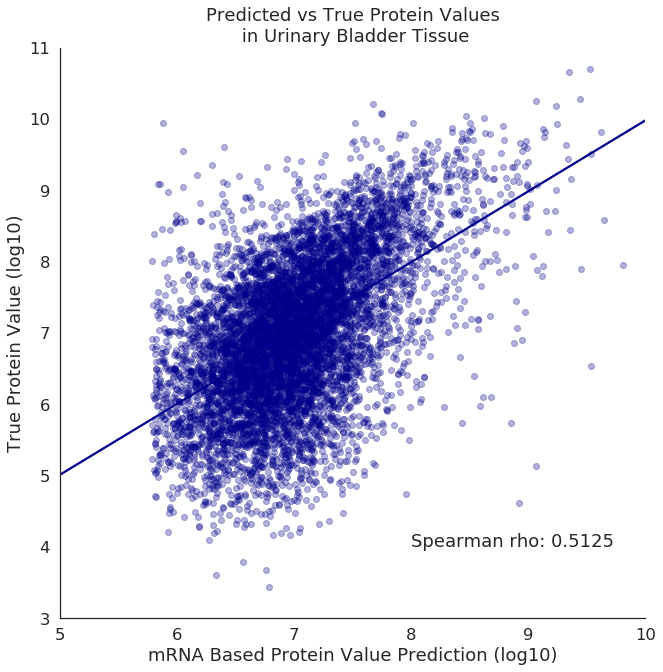

In [65]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(5,10)
ax.set_ylim(3,11)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(8,4,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('mRNA Based Protein Value Prediction (log10)')
ax.set_ylabel('True Protein Value (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein Values\n in Urinary Bladder Tissue')

In [66]:
#fig.savefig('./figures/vanilla_mrna_protein.pdf')

Text(0.5, 1.0, 'Predicted vs True Protein Values\n in Urinary Bladder Tissue')

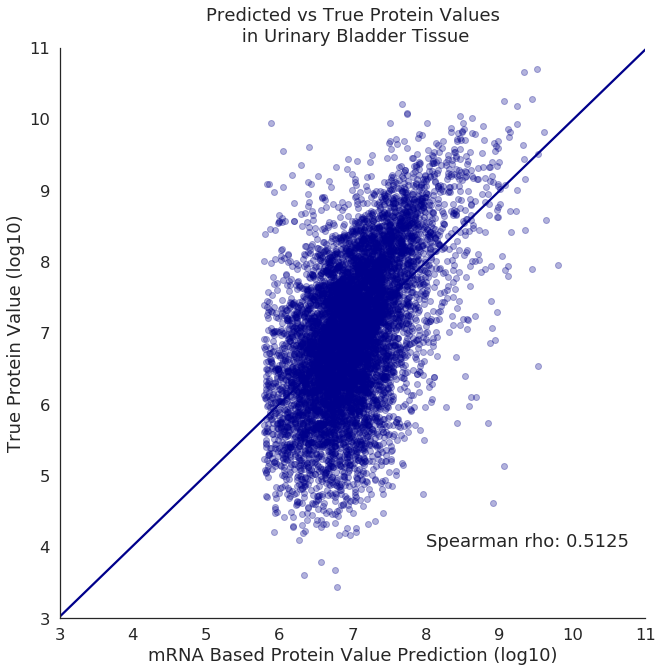

In [67]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(3,11)
ax.set_ylim(3,11)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(8,4,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('mRNA Based Protein Value Prediction (log10)')
ax.set_ylabel('True Protein Value (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein Values\n in Urinary Bladder Tissue')

In [68]:
#fig.savefig('./figures/vanilla_mrna_protein_samescale.pdf')

#### Simple mRNA to protein correlation

In [84]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,[2]].values
y_full = data.iloc[:,[1]].values

plot = {'mrna':x_full.squeeze(),'protein':y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(x_full,y_full)[0]

Text(0.5, 1.0, 'mRNA to Protein linear model and correlation')

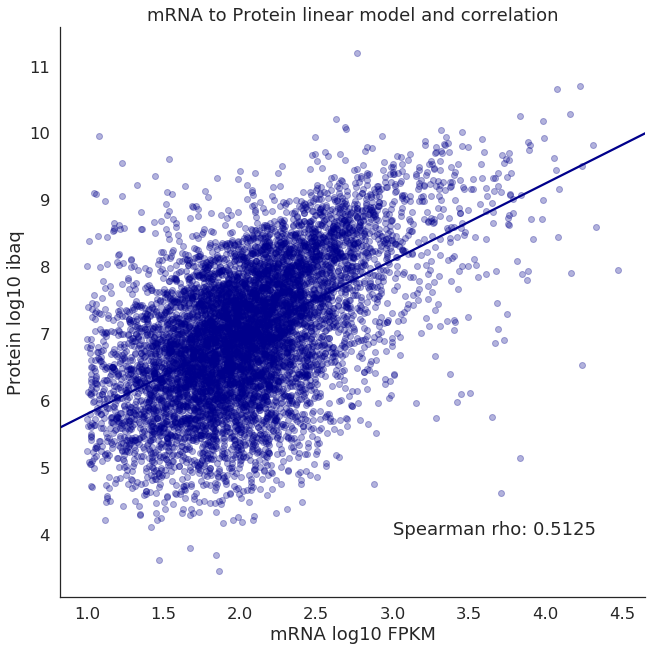

In [85]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
# ax.set_xlim(3,11)
# ax.set_ylim(3,11)

sns.regplot(x='mrna',y='protein',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(3,4,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('mRNA log10 FPKM')
ax.set_ylabel('Protein log10 ibaq')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('mRNA to Protein linear model and correlation')

In [86]:
#fig.savefig('./figures/vanilla_mrna_protein_correlation.pdf')

#### 10 fold cross validation for each tissue using protein length only, predict ratio

In [48]:
#10 fold CV across all tissues

atlas_length = atlas29(ratios,combined_features.iloc[:,[-65]])

length_metrics = pd.DataFrame()

for tissue in tqdm(atlas_length.tissues):
    data = atlas_length.filter_tissue(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,1::]
        y_train = data.iloc[train_index,[0]].values
        x_test = data.iloc[test_index,1::]
        #x_test = data.iloc[:,1::]
        y_test = data.iloc[test_index,[0]].values
        #y_test = data.iloc[:,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    length_metrics = length_metrics.append(mean_cv)
    
length_metrics.mean()

100%|██████████| 29/29 [00:17<00:00,  1.71it/s]


evs              0.048206
mae              0.693024
mean_abs_fc      4.941257
median_abs_fc    3.935089
mse              0.751168
pearsonr         0.229437
pearsonr_p       0.000004
r2               0.046746
smse             0.951776
spearmanrho      0.218465
spearmanrho_p    0.000028
dtype: float64

#### 10 fold cross validation for each tissue using protein embeddings only, metrics are generated on held out set

In [48]:
#10 fold CV across all tissues

#Create atlas object to filter on specific tissues
atlas = atlas29(ratios,combined_features.iloc[:,-64::])

embedding_tissue_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,1::]
        y_train = data.iloc[train_index,[0]].values
        x_test = data.iloc[test_index,1::]
        #x_test = data.iloc[:,1::]
        y_test = data.iloc[test_index,[0]].values
        #y_test = data.iloc[:,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    embedding_tissue_metrics = embedding_tissue_metrics.append(mean_cv)
    
embedding_tissue_metrics.mean()

100%|██████████| 29/29 [00:05<00:00,  5.06it/s]


evs              2.153235e-01
mae              6.178492e-01
mean_abs_fc      4.154708e+00
median_abs_fc    3.264919e+00
mse              6.191599e-01
pearsonr         4.728818e-01
pearsonr_p       2.799636e-30
r2               2.140930e-01
smse             7.846892e-01
spearmanrho      4.643719e-01
spearmanrho_p    1.628102e-28
dtype: float64

In [6]:
#embedding_tissue_metrics.to_csv('./results/ratios_embedding64.tsv',sep='\t')

#### Testing a single fold model on all of the data for the last tissue from above, graph (even though subset) matches paper figure

In [49]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,1::]
y_full = data.iloc[:,[0]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

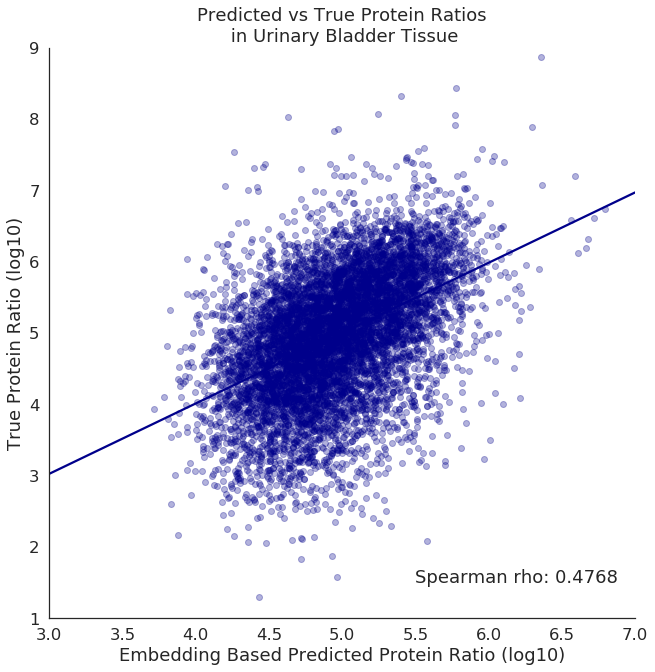

In [50]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(3,7)
ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(5.5,1.5,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('Embedding Based Predicted Protein Ratio (log10)')
ax.set_ylabel('True Protein Ratio (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

In [51]:
#fig.savefig('./figures/ratios_embedding64.pdf')

### Generating figure for paper 4/13

In [120]:
atlas = atlas29(ratios,combined_features.iloc[:,-65::])
tissue = 'Kidney'
data = atlas.filter_tissue(tissue)

from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(data,test_size=0.2)#, random_state=42)

reg_model = linear_model.LinearRegression()
reg_model.fit(x_train.iloc[:,1::], x_train.iloc[:,[0]])
predicted = reg_model.predict(x_test.iloc[:,1::])

In [121]:
compute_metrics(predicted,x_test.iloc[:,[0]].values,x_train.iloc[:,[0]].values)

{'mae': 0.6480646167922256,
 'mse': 0.6684883917516106,
 'smse': 0.7362558719354692,
 'r2': 0.2629534603872711,
 'evs': 0.2629554191190284,
 'spearmanrho': 0.5237657667877624,
 'spearmanrho_p': 6.6402169343055495e-111,
 'pearsonr': 0.5128857639167088,
 'pearsonr_p': 1.1547804351501856e-105,
 'median_abs_fc': 3.5522240096666455,
 'mean_abs_fc': 4.44697427148507}

In [122]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,1::]
y_full = data.iloc[:,[0]].values
predicted = reg_model.predict(x_full)

In [123]:
plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
pearson = compute_metrics(predicted,y_full,y_full)['pearsonr']

Text(0.5, 1.0, 'Predicted vs Observed Protein Ratios\n in Kidney Tissue')

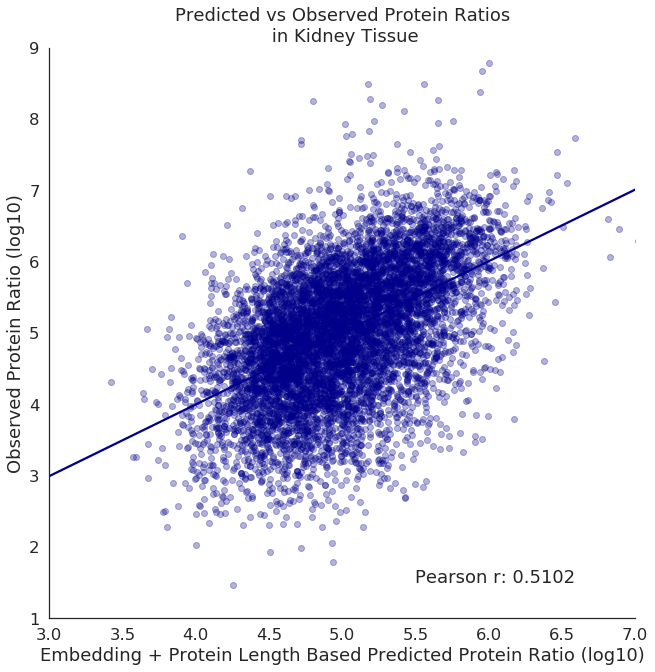

In [124]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(3,7)
ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(5.5,1.5,f'Pearson r: {pearson:.4f}')
ax.set_xlabel('Embedding + Protein Length Based Predicted Protein Ratio (log10)')
ax.set_ylabel('Observed Protein Ratio (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs Observed Protein Ratios\n in Kidney Tissue')

In [66]:
#fig.savefig('./figures/kidney_prediction.png')

#### 10 fold cross validation for each tissue using protein embeddings + length, metrics are generated on held out set

In [52]:
#10 fold CV across all tissues

atlas = atlas29(ratios,combined_features.iloc[:,-65::])

embedding_tissue_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,1::]
        y_train = data.iloc[train_index,[0]].values
        x_test = data.iloc[test_index,1::]
        #x_test = data.iloc[:,1::]
        y_test = data.iloc[test_index,[0]].values
        #y_test = data.iloc[:,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    embedding_tissue_metrics = embedding_tissue_metrics.append(mean_cv)
    
embedding_tissue_metrics.mean()

100%|██████████| 29/29 [00:09<00:00,  5.11it/s]


evs              2.167242e-01
mae              6.172125e-01
mean_abs_fc      4.148523e+00
median_abs_fc    3.260522e+00
mse              6.180251e-01
pearsonr         4.735440e-01
pearsonr_p       2.354292e-30
r2               2.154932e-01
smse             7.832909e-01
spearmanrho      4.658516e-01
spearmanrho_p    1.312947e-28
dtype: float64

In [20]:
#embedding_tissue_metrics.to_csv('./results/ratios_embedding64_protlength.tsv',sep='\t')

#### Testing a single fold model on all of the data for the last tissue from above, graph (even though subset) matches paper figure

In [53]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,1::]
y_full = data.iloc[:,[0]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

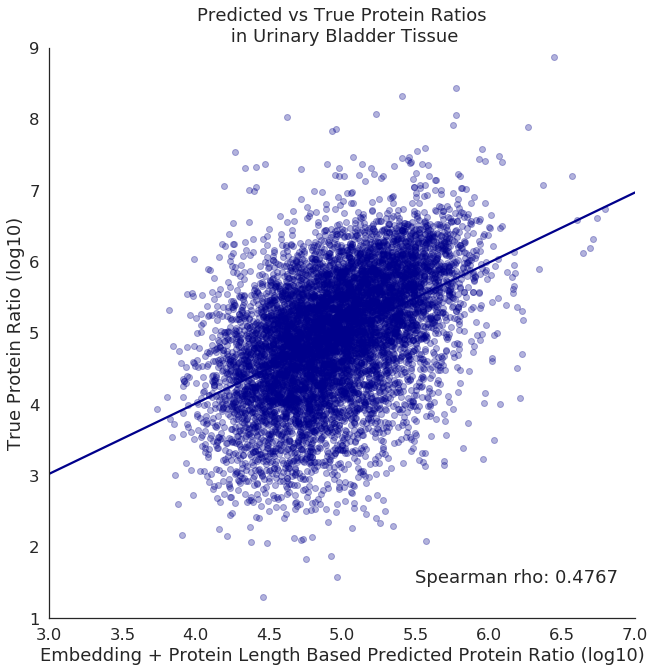

In [54]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.set_xlim(3,7)
ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(5.5,1.5,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('Embedding + Protein Length Based Predicted Protein Ratio (log10)')
ax.set_ylabel('True Protein Ratio (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein Ratios\n in Urinary Bladder Tissue')

In [55]:
#fig.savefig('./figures/ratios_embedding64_protlength.pdf')

#### 10 fold cross validation for each tissue using protein embeddings + original features, metrics are generated on held out set

In [7]:
#10 fold CV across all tissues

#Create atlas object to filter on specific tissues
atlas = atlas29(ratios,combined_features)

full_tissue_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,1::]
        y_train = data.iloc[train_index,[0]].values
        x_test = data.iloc[test_index,1::]
        #x_test = data.iloc[:,1::]
        y_test = data.iloc[test_index,[0]].values
        #y_test = data.iloc[:,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test)
        
        cv_results = cv_results.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    full_tissue_metrics = full_tissue_metrics.append(mean_cv)
    
full_tissue_metrics.mean()

100%|██████████| 29/29 [11:41<00:00, 22.57s/it]


evs              2.527967e-01
mae              6.005599e-01
mean_abs_fc      3.992479e+00
median_abs_fc    3.141267e+00
mse              5.894280e-01
pearsonr         5.112385e-01
pearsonr_p       1.627226e-37
r2               2.516755e-01
smse             7.471619e-01
spearmanrho      5.054243e-01
spearmanrho_p    1.368709e-35
dtype: float64

#### Testing a single fold model on all of the data for the last tissue from above, graph (even though subset) matches paper figure

/gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(1000000, 10, 'spearman rho: 0.5412')

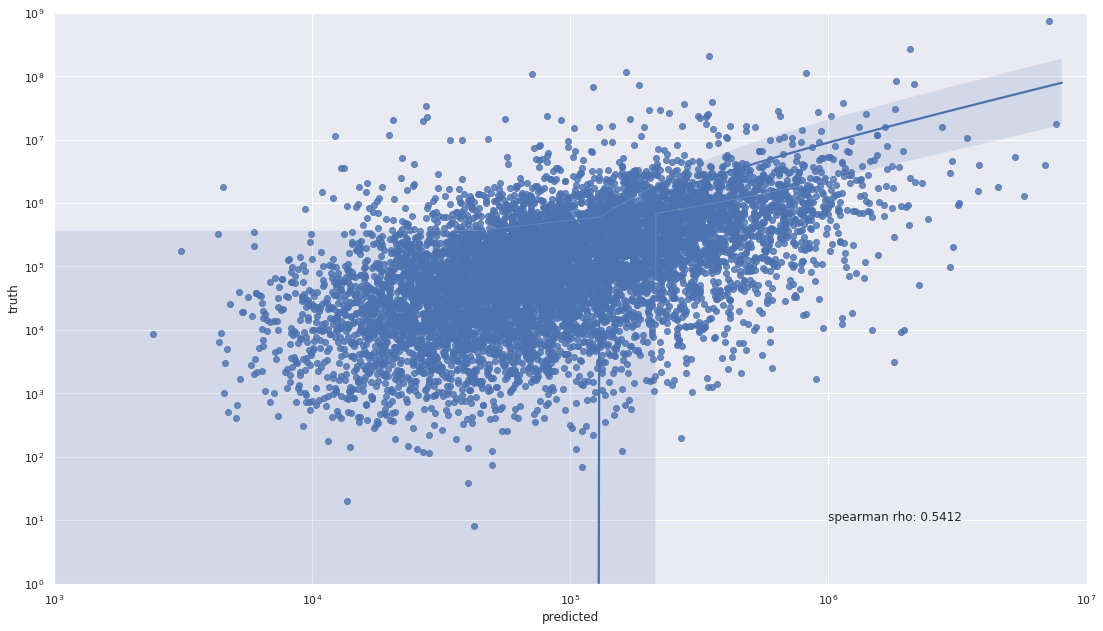

In [8]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,1::]
y_full = data.iloc[:,[0]].values
predicted = reg_model.predict(x_full)
#compute_metrics(predicted,y_full,y_train)

plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
sns.set(color_codes=True)
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]
ax = sns.regplot(x='predicted',y='truth',data=plot_df)
ax.figure.set_size_inches(18.5, 10.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10**3,10**7)
ax.set_ylim(1,10**9)
ax.text(10**6,10**1,f'spearman rho: {spearmanrho:.4f}')

### Protein prediction for paper 4/13

In [156]:
atlas = atlas29(ratios,combined_features.iloc[:,-65::])
tissue = 'Kidney'
data = atlas.filter_tissue_mrna_p(tissue)

x_train, x_test = train_test_split(data,test_size=0.2)#, random_state=42)

reg_model = linear_model.LinearRegression()
reg_model.fit(x_train.iloc[:,2::], x_train.iloc[:,[1]])
predicted = reg_model.predict(x_test.iloc[:,2::])

In [157]:
compute_metrics(predicted,x_test.iloc[:,[1]].values,x_train.iloc[:,[1]].values)

{'mae': 0.657625921380664,
 'mse': 0.6815725235412254,
 'smse': 0.5648716767001303,
 'r2': 0.4339830618257249,
 'evs': 0.43419748755893084,
 'spearmanrho': 0.6532290227517779,
 'spearmanrho_p': 6.04036683077072e-191,
 'pearsonr': 0.662209185407423,
 'pearsonr_p': 5.1659978736573724e-198,
 'median_abs_fc': 3.6319079681024724,
 'mean_abs_fc': 4.545963258954784}

In [158]:
plot = {'predicted':predicted.squeeze(),'truth':x_test.iloc[:,[1]].values.squeeze()}
#plot = {'predicted':10**predicted.squeeze(),'truth':10**y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
pearson = compute_metrics(predicted,x_test.iloc[:,[1]].values,x_train.iloc[:,[1]].values)['pearsonr']

In [159]:
x_full = data.iloc[:,2::]
y_full = data.iloc[:,[1]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]
pearson = compute_metrics(predicted,y_full,x_train.iloc[:,[1]].values)['pearsonr']

Text(0.5, 1.0, 'Predicted vs True Protein iBAQ\n in Kidney Tissue')

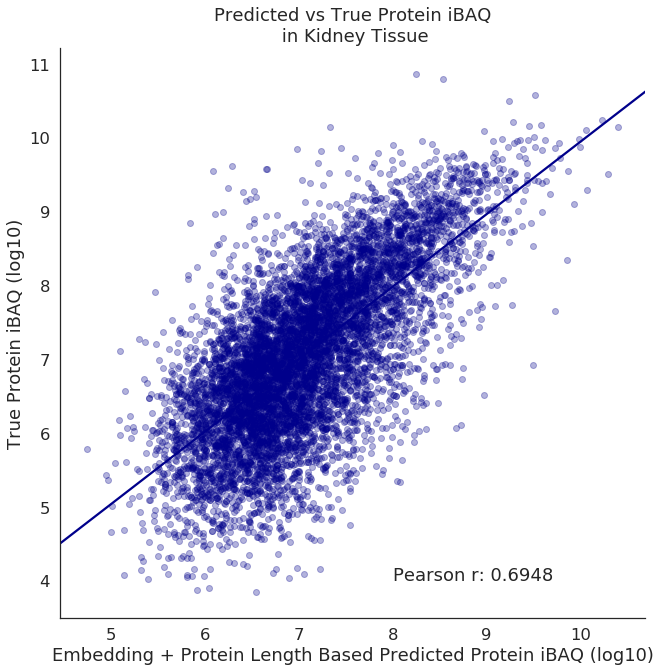

In [160]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
# ax.set_xlim(3,7)
# ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(8,4,f'Pearson r: {pearson:.4f}')
ax.set_xlabel('Embedding + Protein Length Based Predicted Protein iBAQ (log10)')
ax.set_ylabel('True Protein iBAQ (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein iBAQ\n in Kidney Tissue')

In [161]:
#fig.savefig('./figures/kidney_protein_prediction.png')

#### 10 fold cross validation for each tissue using protein embeddings + protein length to predict log10(protein level)

In [87]:
#10 fold CV across all tissues

#Create atlas object to filter on specific tissues
atlas = atlas29(ratios,combined_features.iloc[:,-65::])

full_tissue_metrics = pd.DataFrame()
protein_level_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue_mrna_p(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    cv_results_protein = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,2::]
        y_train = data.iloc[train_index,[1]].values
        ratios_train = data.iloc[train_index,[0]].values
        
        x_test = data.iloc[test_index,2::]
        y_test = data.iloc[test_index,[1]].values
        ratios_test = data.iloc[test_index,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test) #this predicts log10(protein levels)
        
        test_mrna = data.iloc[test_index,[2]].values
        predicted_ratios = np.log10(10**predicted/10**test_mrna) #use predicted protein levels to compute log10(ratios)
        
        cv_results = cv_results.append(compute_metrics(predicted_ratios,ratios_test,ratios_train), ignore_index=True)
        cv_results_protein = cv_results_protein.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    full_tissue_metrics = full_tissue_metrics.append(mean_cv)
    
    mean_cv_protein = cv_results_protein.mean()
    mean_cv_protein.name = tissue
    protein_level_metrics = protein_level_metrics.append(mean_cv_protein)
    
print(full_tissue_metrics.mean())
print(protein_level_metrics.mean()) #metrics for predicted protein levels

100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

evs              2.197014e-01
mae              6.171620e-01
mean_abs_fc      4.147925e+00
median_abs_fc    3.267831e+00
mse              6.156420e-01
pearsonr         4.750860e-01
pearsonr_p       2.561336e-30
r2               2.184729e-01
smse             7.803153e-01
spearmanrho      4.691527e-01
spearmanrho_p    1.143105e-28
dtype: float64
evs              4.501738e-01
mae              6.171607e-01
mean_abs_fc      4.147913e+00
median_abs_fc    3.267713e+00
mse              6.156403e-01
pearsonr         6.523421e-01
pearsonr_p       7.617067e-63
r2               4.493108e-01
smse             5.499445e-01
spearmanrho      6.708667e-01
spearmanrho_p    3.679994e-70
dtype: float64


In [89]:
#protein_level_metrics.to_csv('./results/proteins_embedding64_protlength.tsv',sep='\t')

In [98]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,2::]
y_full = data.iloc[:,[1]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein iBAQ\n in Urinary Bladder Tissue')

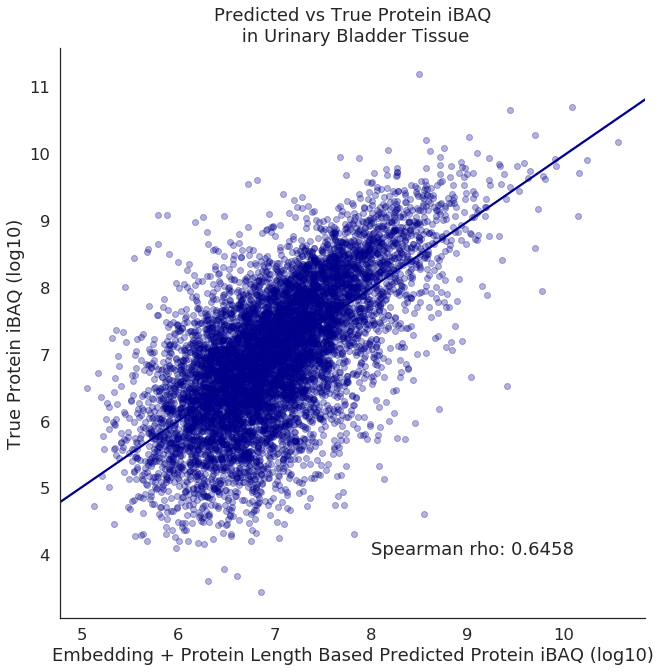

In [101]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
# ax.set_xlim(3,7)
# ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(8,4,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('Embedding + Protein Length Based Predicted Protein iBAQ (log10)')
ax.set_ylabel('True Protein iBAQ (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein iBAQ\n in Urinary Bladder Tissue')

In [102]:
#fig.savefig('./figures/proteins_embedding64_protlength.pdf')

#### 10 fold cross validation for each tissue using paper feautres to predict log10(protein level)

In [103]:
#10 fold CV across all tissues

#Create atlas object to filter on specific tissues
atlas = atlas29(ratios,combined_features.iloc[:,0:204])

full_tissue_metrics = pd.DataFrame()
protein_level_metrics = pd.DataFrame()

for tissue in tqdm(atlas.tissues):
    data = atlas.filter_tissue_mrna_p(tissue)
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

    cv_results = pd.DataFrame()
    cv_results_protein = pd.DataFrame()
    for train_index, test_index in kf.split(data):

        reg_model = linear_model.LinearRegression()

        x_train = data.iloc[train_index,2::]
        y_train = data.iloc[train_index,[1]].values
        ratios_train = data.iloc[train_index,[0]].values
        
        x_test = data.iloc[test_index,2::]
        y_test = data.iloc[test_index,[1]].values
        ratios_test = data.iloc[test_index,[0]].values

        reg_model.fit(x_train, y_train)
        predicted = reg_model.predict(x_test) #this predicts log10(protein levels)
        
        test_mrna = data.iloc[test_index,[2]].values
        predicted_ratios = np.log10(10**predicted/10**test_mrna) #use predicted protein levels to compute log10(ratios)
        
        cv_results = cv_results.append(compute_metrics(predicted_ratios,ratios_test,ratios_train), ignore_index=True)
        cv_results_protein = cv_results_protein.append(compute_metrics(predicted,y_test,y_train), ignore_index=True)

    mean_cv = cv_results.mean()
    mean_cv.name = tissue
    full_tissue_metrics = full_tissue_metrics.append(mean_cv)
    
    mean_cv_protein = cv_results_protein.mean()
    mean_cv_protein.name = tissue
    protein_level_metrics = protein_level_metrics.append(mean_cv_protein)
    
print(full_tissue_metrics.mean()) #Evaluataing ratios from predicted proteins
print(protein_level_metrics.mean()) #Evaluating predicted proteins to truth

100%|██████████| 29/29 [00:19<00:00,  1.53it/s]

evs              2.218394e-01
mae              6.175647e-01
mean_abs_fc      4.152133e+00
median_abs_fc    3.281942e+00
mse              6.139373e-01
pearsonr         4.768517e-01
pearsonr_p       1.504034e-30
r2               2.206472e-01
smse             7.781418e-01
spearmanrho      4.732175e-01
spearmanrho_p    1.441807e-28
dtype: float64
evs              4.517000e-01
mae              6.175634e-01
mean_abs_fc      4.152122e+00
median_abs_fc    3.281870e+00
mse              6.139354e-01
pearsonr         6.556606e-01
pearsonr_p       5.684607e-58
r2               4.508588e-01
smse             5.483964e-01
spearmanrho      6.723850e-01
spearmanrho_p    1.715632e-66
dtype: float64


In [105]:
#protein_level_metrics.to_csv('./results/proteins_original_204features.tsv',sep='\t')

In [106]:
#Testing submodel on all the data for last tissue from above
x_full = data.iloc[:,2::]
y_full = data.iloc[:,[1]].values
predicted = reg_model.predict(x_full)

plot = {'predicted':predicted.squeeze(),'truth':y_full.squeeze()}
plot_df = pd.DataFrame.from_dict(plot,orient='index').T
spearmanrho = scipy.stats.spearmanr(y_full,predicted)[0]

Text(0.5, 1.0, 'Predicted vs True Protein iBAQ\n in Urinary Bladder Tissue')

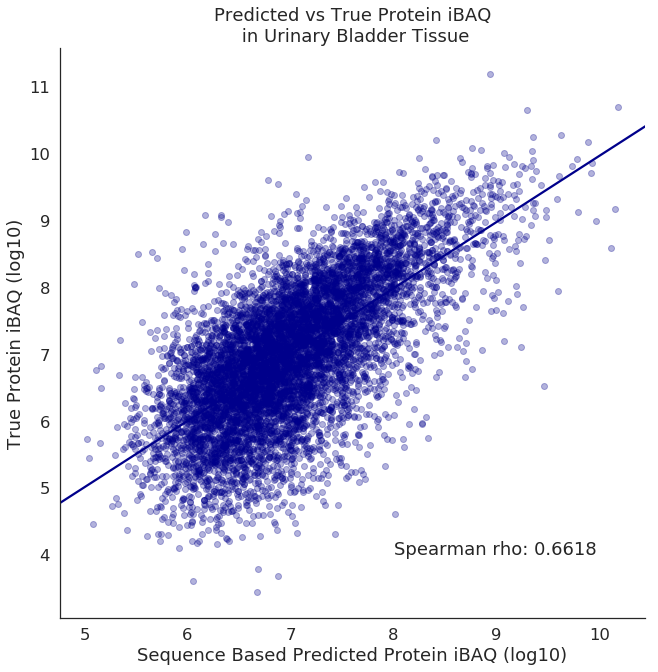

In [108]:
sns.set(style="white", color_codes=True,font_scale=1.5)

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
# ax.set_xlim(3,7)
# ax.set_ylim(1,9)
sns.regplot(x='predicted',y='truth',data=plot_df,ci=None,scatter_kws={'alpha':0.3},color='darkblue',ax=ax)
ax.text(8,4,f'Spearman rho: {spearmanrho:.4f}')
ax.set_xlabel('Sequence Based Predicted Protein iBAQ (log10)')
ax.set_ylabel('True Protein iBAQ (log10)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Predicted vs True Protein iBAQ\n in Urinary Bladder Tissue')

In [109]:
#fig.savefig('./figures/proteins_original_204features.pdf')